In [12]:
def preprocess_data(df):
    class0_df = df[df['isFraud'] == 0] ## majority class, will be used for autoencoder training
    class1_df = df[df['isFraud'] == 1]
    ##
    class0_arr = np.array(class0_df.drop('isFraud',axis = 1)) 
    class1_arr = np.array(class1_df.drop('isFraud',axis = 1))
    X = class0_arr
    X_train, X_test = train_test_split(X, test_size=0.1)
    X_train, X_val = train_test_split(X_train, test_size=0.1)
    
    print("====><>>>>>")
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    return X_train, X_val, X_test, class1_arr

In [3]:
dataset = pd.read_csv("../input/Fraud/backup.csv")

In [11]:
dataset = dataset.drop('Unnamed: 0', axis = 1)

In [6]:
dataset = pd.get_dummies(dataset,prefix=['type'])

In [15]:
X_train, X_val, X_test, class1_arr = preprocess_data(dataset)
n_features = X_train.shape[1]

====><>>>>>


In [16]:
n_features

12

<AxesSubplot:>

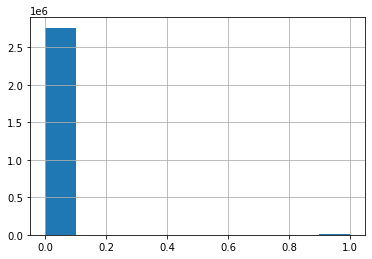

In [17]:
dataset.isFraud.hist()

In [18]:
print("Train Size: {}".format(len(X_train)))
print("Val Size: {}".format(len(X_val)))
print("Test Size: {}".format(len(X_test)))
print("No of Features: {}".format(n_features))

Train Size: 2237378
Val Size: 248598
Test Size: 276220
No of Features: 12


In [19]:
# model archticeture

def build_model():
    model = keras.Sequential([
        keras.Input(shape=(n_features,)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.BatchNormalization(),
        
        keras.layers.Dense(32, activation='relu'),
        keras.layers.BatchNormalization(),
        
        keras.layers.Dense(16, activation='relu'),
        keras.layers.BatchNormalization(),
        
        keras.layers.Dense(32, activation='relu'),
        keras.layers.BatchNormalization(),
        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.BatchNormalization(),
        
        keras.layers.Dense(n_features)
    ])
    
    return model

In [20]:
# model building
model = build_model()

In [21]:
# model compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse', metrics=['accuracy'])

In [24]:
# callbacks defined

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 5
    lrate = initial_lrate * (drop**((1 + epoch)/epochs_drop))
    return lrate

lrate_scheduler = LearningRateScheduler(step_decay)
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model_chkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# model fitting
model.fit(X_train, X_train, batch_size=512, epochs=10, validation_data=(X_val, X_val), callbacks=[early_stop, model_chkpoint, lrate_scheduler])

Train on 2237378 samples, validate on 248598 samples
Epoch 1/10
2236928/2237378 [============================>.] - ETA: 0s - loss: 0.0260 - accuracy: 0.9412
Epoch 00001: val_loss improved from inf to 0.07393, saving model to best_model.h5
2237378/2237378 [==============================] - 62s 28us/sample - loss: 0.0260 - accuracy: 0.9412 - val_loss: 0.0739 - val_accuracy: 0.8942
Epoch 2/10
2235904/2237378 [============================>.] - ETA: 0s - loss: 0.0192 - accuracy: 0.9478
Epoch 00002: val_loss improved from 0.07393 to 0.00786, saving model to best_model.h5
2237378/2237378 [==============================] - 60s 27us/sample - loss: 0.0192 - accuracy: 0.9478 - val_loss: 0.0079 - val_accuracy: 0.9550
Epoch 3/10
2235904/2237378 [============================>.] - ETA: 0s - loss: 0.0172 - accuracy: 0.9501
Epoch 00003: val_loss improved from 0.00786 to 0.00540, saving model to best_model.h5
2237378/2237378 [==============================] - 62s 28us/sample - loss: 0.0172 - accuracy: 0

In [32]:
def rel(y_test,y_pred):
    predictionsRFR=np.array(y_pred,dtype='int') 
    CM_RFR = confusion_matrix(y_test,predictionsRFR)
    CR_RFR = classification_report(y_test,predictionsRFR)
    fprRFR, recallRFR, thresholdsRFR = roc_curve(y_test, predictionsRFR)
    AUC_RFR = auc(fprRFR, recallRFR)
    print("=============<>==================\n")
    resultsRFR = {"Confusion Matrix":CM_RFR,"Classification Report":CR_RFR,"Area Under Curve":AUC_RFR}
    for measure in resultsRFR:
        print(measure,": \n",resultsRFR[measure])
    print("=============<>==================\n")

In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve


def reconstruction_error(actual, pred):
    return np.mean((actual - pred)**2, axis=1)

def evaluate(model, X, y):
    X = X.reshape(-1, n_features)
    out = reconstruction_error(X, model.predict(X))
    print("AUC score: {}".format(roc_auc_score(y, out)))
    print("PR score: {}".format(average_precision_score(y, out)))
    print("\n\n")
    for th in [0.5, 0.6, 0.7, 0.8, 0.9, 1., 1.1 , 1.2, 1.3, 1.4, 1.5, 1.75, 2, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]:
        out_th = [1 if (o > th) else 0 for o in out]
        print("TH - {}".format(th))
        print("Precision: {}".format(precision_score(y, out_th)))
        print("Recall: {}".format(recall_score(y, out_th)))
        print("F1score: {}".format(f1_score(y, out_th)))
        rel(y,out_th)
        print("\n\n")

In [34]:
final_X_test = np.concatenate((X_test, class1_arr))
final_Y_test = np.concatenate(([0]*len(X_test), [1]*len(class1_arr)))

In [37]:
# Metrics
evaluate(model, final_X_test, final_Y_test)

AUC score: 1.0
PR score: 1.0



TH - 0.5
Precision: 0.9928675048355899
Recall: 1.0
F1score: 0.9964209887776767
=============<>==================

Confusion Matrix : 
 [[276161     59]
 [     0   8213]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    276220
           1       0.99      1.00      1.00      8213

    accuracy                           1.00    284433
   macro avg       1.00      1.00      1.00    284433
weighted avg       1.00      1.00      1.00    284433

Area Under Curve : 
 0.9998932010716095
=============<>==================




TH - 0.6
Precision: 0.993708408953418
Recall: 1.0
F1score: 0.996844277218109
=============<>==================

Confusion Matrix : 
 [[276168     52]
 [     0   8213]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    276220
           1       0.99      1.00      1.00      8213

    accur

In [28]:
import matplotlib.pyplot as plt
out = reconstruction_error(final_X_test, model.predict(final_X_test))

No handles with labels found to put in legend.


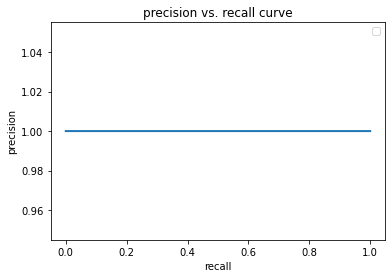

In [29]:
precision, recall, _ = precision_recall_curve(final_Y_test, out)
plt.plot(recall, precision, lw=2)
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

No handles with labels found to put in legend.


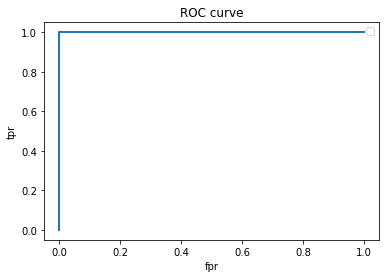

In [30]:
fpr, tpr, _ = roc_curve(final_Y_test, out)
                        
plt.plot(fpr, tpr, lw=2)
    
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()